In [161]:
# Importation librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

<img src='./images/logo-lapage-sans-fond.png' width=240px />

# Analysez les ventes d'une librairie avec Python

Nous sommes consultant *Data Analyst*, rattaché au service Marketing chez Lapage qui est une grande librairie en ligne très réputée. Lapage était originellement une librairie physique avec plusieurs points de vente. Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne. L’entreprise souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc..

## Sommaire<a id='0'></a>

* [Préparation des données source](#1)
    * [Importation](#1-1)
    * [Type des données](#1-2)
    * [Enregistrements test](#1-3)
    * [Valeurs manquantes](#1-4)
    * [Doublons ids](#1-5)
    * [Cohérence des données](#1-6)
    * [Regroupement des bases](#1-7)
* [Indicateurs de vente](#2)
    * [Chiffre d'affaires](#2-1)

## Préparation des données source<a id='1'></a>

Un traitement identique est appliqué, si nécessaire, à chaque fichier CSV qui compose la base données :
* chargement dans un *DataFrame* ;
* vérification de l'importation ;
* renommage des variables ;
* vérification du type des données ;
* suppression des variables inutiles ;
* vérification des valeurs manquantes et/ou des doublons.

Les *DataFrames* seront ensuite regroupés afin de nous permettre de mener les analyses demandées.

### Importation<a id='1-1'></a>

In [162]:
df_products = pd.read_csv('./datasets/products.csv')
df_customers = pd.read_csv('./datasets/customers.csv')
df_transactions = pd.read_csv('./datasets/transactions.csv')

In [163]:
df_products.head(3)

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0


In [164]:
df_customers.head(3)

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984


In [165]:
df_transactions.head(3)

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714


Il ne semble pas y avoir de variables à supprimer. Par contre, pour faciliter la compréhension, les noms de variables abrégés vont être renommés de manière explicite et vont être harmonisés.

In [166]:
# Renommage variables
df_products = df_products.rename(
    columns={'id_prod':'product_id', 'categ':'category'})

df_customers = df_customers.rename(
    columns={'birth':'birth_year'})

df_transactions = df_transactions.rename(
    columns={'id_prod':'product_id', 'date':'transaction_date'})

Voyons les dimensions des jeux de données.

In [167]:
# Dimensions DataFrames
print(f'Les dimensions de "df_products" sont : {df_products.shape}')
print(f'Les dimensions de "df_customers" sont : {df_customers.shape}')   
print(f'Les dimensions de "df_transactions" sont : {df_transactions.shape}')

Les dimensions de "df_products" sont : (3287, 3)
Les dimensions de "df_customers" sont : (8623, 3)
Les dimensions de "df_transactions" sont : (679532, 4)


### Type des données<a id='1-2'></a>

In [168]:
df_products.dtypes

product_id     object
price         float64
category        int64
dtype: object

"category" est une variable quantitative qui prend un nombre fini de valeurs, nous allons changer sont en "category" justement.

In [169]:
df_products['category'] = df_products['category'].astype('category')

In [170]:
df_customers.dtypes

client_id     object
sex           object
birth_year     int64
dtype: object

Pour la même raison, la même modification va être faite pour "sex" et "birth_year".

In [171]:
df_customers['sex'] = df_customers['sex'].astype('category')
df_customers['birth_year'] = df_customers['birth_year'].astype('category')

In [172]:
df_transactions.dtypes

product_id          object
transaction_date    object
session_id          object
client_id           object
dtype: object

Ici, seule la date n'est pas dans le bon format.

In [173]:
try:
    df_transactions['transaction_date'] = pd.to_datetime(
        df_transactions['transaction_date'])
except ValueError as erreur:
    print(erreur)

Unknown string format: test_2021-03-01 02:30:02.237419 present at position 3019


La conversion a échoué et on constate que la ligne 3019 ligne contient la mention "test_" avant la date. Voyons si d'autres lignes sont concernées.

In [174]:
df_transactions.query('transaction_date.str.contains(\'test\')')

,product_id,transaction_date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


200 lignes correspondent à des tests. Supprimons-les pour ne pas fausser les futures analyses puis, revenons au traitement de la date.<br>
&#9888; Notons qu'il existe également un ou des produit(s) test ("T_") et des clients test ("ct_") qu'il faudra supprimer des *DataFrames* concernés.

In [175]:
# Suppression lignes de test
df_transactions = df_transactions.drop(
    df_transactions.query('transaction_date.str.contains(\'test\')').index
).reset_index(drop=True)

# Conversion date
df_transactions['transaction_date'] =  pd.to_datetime(
    df_transactions['transaction_date'])

### Enregistrements test<a id='1-3'></a>

Nous avons trouvé dans les transactions des lignes qui correspondent à des tests. On doit retrouver les produits et clients correspondant dans leur *DataFrame* respectif.

In [176]:
df_products.query('product_id.str.contains(\'T\')')

,product_id,price,category
731,T_0,-1.0,0


In [177]:
df_customers.query('client_id.str.contains(\'ct\')')

,client_id,sex,birth_year
2735,ct_0,f,2001
8494,ct_1,m,2001


Il y a donc un produit test, un client test féminin et un client test masculin à supprimer.

In [178]:
# Suppression des tests
df_products = df_products.drop(
    df_products.query('product_id.str.contains(\'T\')').index
    ).reset_index(drop=True)

df_customers = df_customers.drop(
    df_customers.query('client_id.str.contains(\'ct\')').index
    ).reset_index(drop=True)

### Valeurs manquantes<a id='1-4'></a>

In [179]:
na_products = df_products.isna().sum().sum()
print(f'Nombre de valeurs manquantes dans "df_products" : {na_products}.')

na_customers = df_customers.isna().sum().sum()
print(f'Nombre de valeurs manquantes dans "df_customers" : {na_customers}.')

na_transactions = df_transactions.isna().sum().sum()
print(f'Nombre de valeurs manquantes dans "df_transactions" : {na_transactions}.')

del na_products, na_customers, na_transactions

Nombre de valeurs manquantes dans "df_products" : 0.
Nombre de valeurs manquantes dans "df_customers" : 0.
Nombre de valeurs manquantes dans "df_transactions" : 0.


Tous nos jeux de données sont complets.

### Doublons ids<a id='1-5'></a>

In [180]:
duplicate_products = df_products.duplicated(subset='product_id').sum()
print(f'Nombre de doublons dans "df_products" : {duplicate_products}.')

duplicate_customers = df_customers.duplicated(subset='client_id').sum()
print(f'Nombre de doublons dans "df_customers" : {duplicate_customers}.')

# On vérifie que les transactions sont uniques à une date donnée
duplicate_transactions = df_transactions.duplicated(
    subset=['session_id', 'transaction_date']
).sum()
print(f'Nombre de doublons dans "df_transactions" : {duplicate_transactions}.')

del duplicate_products, duplicate_customers, duplicate_transactions

Nombre de doublons dans "df_products" : 0.
Nombre de doublons dans "df_customers" : 0.
Nombre de doublons dans "df_transactions" : 0.


### Cohérence des données<a id='1-6'></a>

* Les catégories des produits sont-elles en nombre limité et y-a-t'il des valeurs qui semblent incohérentes?

In [181]:
categories =  df_products['category'].unique().tolist()
print(f'Les différentes catégories sont : {categories}.')
del categories

Les différentes catégories sont : [0, 1, 2].


* Le premier caractère de "product_id" correspond à la catégorie du produit?

In [182]:
test_id_category = (df_products['product_id'].str[0].astype('int')
                    == df_products['category'].astype('int')).all()
print(f'Le premier caractère de "product_id" est la catégorie : {test_id_category}.')
del test_id_category

Le premier caractère de "product_id" est la catégorie : True.


* Des produits ont-ils un prix inférieur ou égal à 0?

In [183]:
test_price = (df_products['price'] <= 0).any()
print(f'Tous les prix sont bien ≥ 0 : {~test_price}.')
del test_price

Tous les prix sont bien ≥ 0 : True.


* Le sexe des clients est-il toujours soit "f", soit "m"?

In [184]:
genders = df_customers['sex'].unique().tolist()
print(f'Les différentes valeurs de "sex" sont : {genders}.')
del genders

Les différentes valeurs de "sex" sont : ['f', 'm'].


* Les années de naissances des clients sont-elles cohérentes?

In [185]:
df_customers['birth_year'].unique().sort_values()

[1929, 1930, 1931, 1932, 1933, ..., 2000, 2001, 2002, 2003, 2004]
Length: 76
Categories (76, int64): [1929, 1930, 1931, 1932, ..., 2001, 2002, 2003, 2004]

Tout semble correct: les valeurs sont comprises entre 1929 et 2004 et il n'y a que des années composées de quatre chiffres.

* Les transactions sont-elles enregistrées sur des années qui correspondent à la date d'ouverture du site en ligne?

In [186]:
df_transactions['transaction_date'].dt.year.value_counts().sort_index()

2021    278335
2022    346500
2023     54497
Name: transaction_date, dtype: int64

Le site a ouvert il y a deux ans et il y a des transactions sur trois années. Vérifions qu'il n'y a bien que deux ans d'enregistrements.

In [187]:
first_date = df_transactions['transaction_date'].min()
last_date = df_transactions['transaction_date'].max()
print(
    f'Date du premier enregistrement : {first_date}.\n'
    f'Date du dernier enregistrement : {last_date}.'
)
del first_date, last_date

Date du premier enregistrement : 2021-03-01 00:01:07.843138.
Date du dernier enregistrement : 2023-02-28 23:58:30.792755.


Le site n'a pas été mis en ligne au mois de janvier ce qui explique qu'il y ait trois années dans les données.

### Regroupement des bases<a id='1-7'></a>

On ajoute aux transactions les informations concernant les produits et les clients dans un nouveau *DataFrame* appelé `df_final`.

In [188]:
# Ajout des informations produits
df_final = pd.merge((df_transactions), (df_products), on =['product_id'], how ='left')

# Ajout des informations clients
df_final = pd.merge((df_final), (df_customers), on =['client_id'], how ='left')

df_final.head(3)

,product_id,transaction_date,session_id,client_id,price,category,sex,birth_year
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0,f,1986
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,15.99,1,m,1988
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,7.99,0,f,1968


Les données semblent correctes, voyons la taille du nouveau jeu de données.

In [189]:
print(f'Les dimensions de "df_final" sont: {df_final.shape}')

Les dimensions de "df_final" sont: (679332, 8)


Le nombre de lignes est bon. `df_transactions` avait 679532 enregistrements desquels nous avons supprimé 200 test.<br>
Pour faciliter la lecture, nous allons réorganiser l'ordre des colonnes.

In [190]:
df_final = df_final[
    ['session_id',
    'transaction_date',
    'product_id',
    'category',
    'price',
    'client_id',
    'sex',
    'birth_year']
]

En fin, vérifions si il y a des valeurs manquantes.

In [191]:
df_final.isna().sum()

session_id            0
transaction_date      0
product_id            0
category            221
price               221
client_id             0
sex                   0
birth_year            0
dtype: int64

221 enregistrements n'ont ni prix, ni catégorie. Voyons combien de produits sont concernés.

In [192]:
# Calcul nombre de produits sans prix/catégorie
products_na = df_final['product_id'].isna().nunique()
products_sum = df_final['product_id'].nunique()
print(f'Il y a {products_na} produit(s) non renseigné(s) sur {products_sum}.')

# Calcul pourcentage transactions concernées
pct_transactions_na = (df_final.isna().any(axis='columns').sum()
                       / len(df_final.index))
print(f'Cela représente {pct_transactions_na:.3%} des transactions.')

del products_na, products_sum, pct_transactions_na

Il y a 1 produit(s) non renseigné(s) sur 3266.
Cela représente 0.033% des transactions.


Supprimer ces lignes n'aura donc pas d'impact sur les analyses.

In [193]:
df_final = df_final.dropna(axis='rows', how='any').reset_index(drop=True)

Le jeu de données final est prêt. Les *DataFrames* sources ne sont plus utiles, on peut les supprimer.

In [194]:
del df_products, df_customers, df_transactions

## Indicateurs de vente<a id='2'></a>

* indicateurs et graphiques autour du chiffre d'affaires
* l’évolution dans le temps et mettre en place une décomposition en moyenne mobile pour évaluer la tendance globale
* faire un zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.
* quelques informations sur les profils de nos clients, et également la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz
* heatmap traffic horaire

In [195]:
df_final.head(3)

,session_id,transaction_date,product_id,category,price,client_id,sex,birth_year
0,s_211425,2022-05-20 13:21:29.043970,0_1518,0,4.18,c_103,f,1986
1,s_158752,2022-02-02 07:55:19.149409,1_251,1,15.99,c_8534,m,1988
2,s_225667,2022-06-18 15:44:33.155329,0_1277,0,7.99,c_6714,f,1968


### Chiffre d'affaires <a id='2-1'></a>

#### Résultats annuels

In [234]:
# Fonction de calcul résulats annuels
def table_TO_per_year():
    years = df_final['transaction_date'].sort_values().dt.year.unique()
    TO_total = round(df_final['price'].sum()/1000,2)
    
    print(f'Chiffre d\'affaires réalisé :')

    for year in years:
        TO_per_year = round(
            df_final.loc[df_final['transaction_date'].dt.year == year, 'price'].sum()
            /1000, 2)
            
        print(f'- {year} :  {TO_per_year:>12} k€')

    print(f'- Total : {TO_total:>12} k€')

table_TO_per_year()

Chiffre d'affaires réalisé :
- 2021 :       4770.83 k€
- 2022 :       6108.68 k€
- 2023 :        974.22 k€
- Total :     11853.73 k€


#### Résultats mensuels

In [250]:
# Fontion de calcul des résultats mensuels
def table_TO_per_month(df):
    TO_per_month = (df[['transaction_date', 'price']]
                        .sort_values('transaction_date')).groupby(
        pd.Grouper(key='transaction_date', freq='MS')
        ).sum().reset_index()

    min_TO_month = TO_per_month['price'].min()/1000
    max_TO_month = TO_per_month['price'].max()/1000
    avg_TO_month = TO_per_month['price'].mean()/1000
    med_TO_month = TO_per_month['price'].median()/1000

    print(
        f'Chiffre d\'affaires mensuel :\n'
        f'Minimum :\t{min_TO_month:.2f} k€\n'
        f'Maximum :\t{max_TO_month:.2f} k€\n'
        f'Moyen :\t\t{avg_TO_month:.2f} k€\n'
        f'Médian :\t{med_TO_month:.2f} k€\n'
    )
table_TO_per_month(df_final)

Chiffre d'affaires mensuel :
Minimum :	320.80 k€
Maximum :	535.57 k€
Moyen :		493.91 k€
Médian :	501.57 k€



#### Evolution du chiffre d'affaires

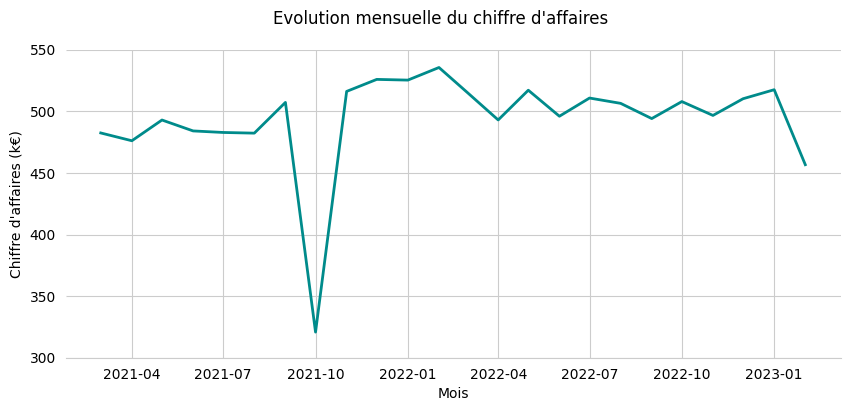

In [253]:
# Fonction de préparation des données et de traçage du graphique
def plot_TO_per_month(df):
    df_temp = (df[['transaction_date', 'price']]
                    .sort_values('transaction_date')).groupby(
        pd.Grouper(key='transaction_date', freq='MS')
        ).sum().reset_index()

    dates = df_temp["transaction_date"]
    turnover = df_temp["price"]
    
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('0.8')

    ax.grid(axis='both', which='both', color='0.8')

    ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: format(int(x/1000))))
    ax.tick_params(axis='both', which='both', color='1.0')

    ax.set_xlabel('Mois')
    ax.set_ylabel('Chiffre d\'affaires (k€)')

    ax.plot(dates, turnover, color='darkcyan', linewidth=2)
    
    fig.suptitle('Evolution mensuelle du chiffre d\'affaires')
    
    plt.ylim(300000, 550000)
    
    plt.show()
    
plot_TO_per_month(df_final)

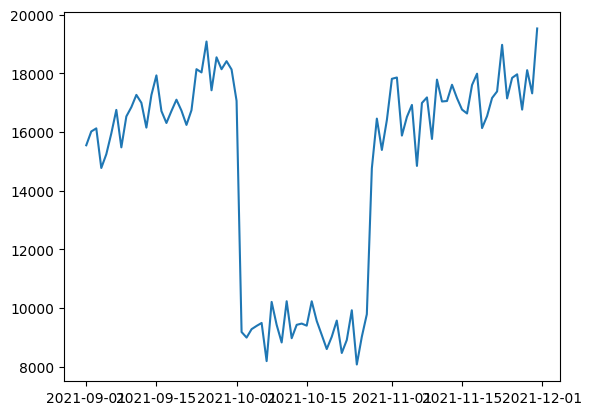

In [283]:
az = (df_final[['transaction_date', 'price']]
                .sort_values('transaction_date')).groupby(
    pd.Grouper(key='transaction_date', freq='D')
    ).sum().reset_index()



az = az.loc[(az['transaction_date'] >= '2021-09-01') & (az['transaction_date'] <= '2021-11-30')]

az

x = az['transaction_date']
y = az['price']

plt.plot(x,y)

#### Tops et flops

Faire en quantité + CA

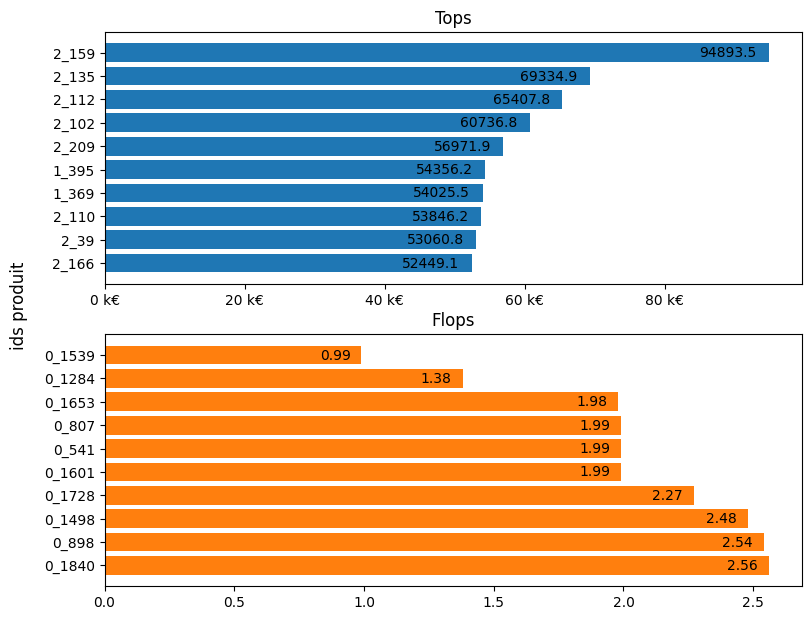

In [200]:
df_temp = df_final.groupby('product_id')['price'].sum()

x0= df_temp.nlargest(10).sort_values().index
y0 = df_temp.nlargest(10).sort_values().values
x1= df_temp.nsmallest(10).sort_values(ascending=False).index
y1= df_temp.nsmallest(10).sort_values(ascending=False).values

fig, axs = plt.subplots(2, 1, figsize=(9, 7.2))

plot0 = axs[0].barh(x0, y0)
axs[0].bar_label(plot0, padding=-50)
axs[0].set_title('Tops')
axs[0].get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x/1000))+' k€'))

cmap = plt.get_cmap('Oranges')


plot1 = axs[1].barh(x1, y1, color='C1')
axs[1].bar_label(plot1, padding=-30)
axs[1].set_title('Flops')


fig.supylabel('ids produit')


plt.show()

#### Chiffre d'affaires par catégorie

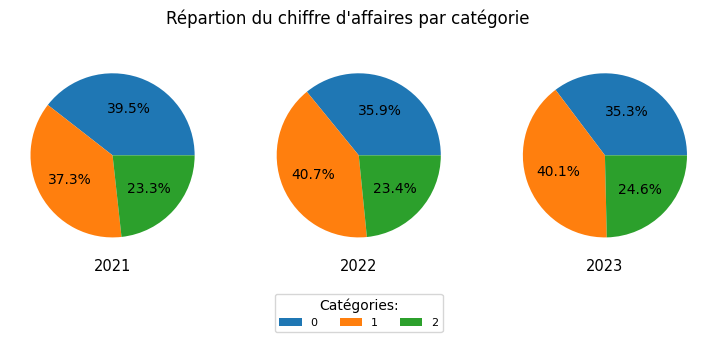

In [201]:
def plot_TO_per_category(df):
    # Préparation des données
    df_temp = (df[['transaction_date', 'category', 'price']]
               .sort_values('transaction_date')
               .copy()
    )
    df_temp['transaction_date'] = df_temp['transaction_date'].dt.year
    df_temp = (df_temp.groupby(['transaction_date', 'category'])['price']
                   .sum()
                   .reset_index()
    )

    years = df_temp['transaction_date'].unique()
    categories = df_temp['category'].unique()

    # Traçage grahique(s)
    fig, axs = plt.subplots(1, len(years), figsize=((len(years)*3), 3.6))

    for i in range(len(years)):
        TO_sum = df_temp.loc[df_temp['transaction_date'] == years[i]
                             , 'price'].values
        
        axs[i].pie(TO_sum, autopct = '%.1f%%')
        axs[i].set_title(years[i], y=-0.1, size=10.5)
   
    fig.suptitle('Répartion du chiffre d\'affaires par catégorie', y=0.9)
    fig.legend(categories, ncols = 3, title='Catégories:', loc='lower center'
        , fontsize=8)
    
    plt.show()
    
plot_TO_per_category(df_final)